In [52]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn import datasets
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape

## Load mnist dataset from sklearn

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(name='mnist_784')

### Reshape images to proper 28x28 format

In [3]:
nr_images = len(mnist.data.values)
all_images = mnist.data.values.reshape((nr_images, 28, 28))
all_labels = np.array(mnist.target.values)

## Visualize digits from the dataset

In [4]:
images = all_images[0:4]
labels = np.array(mnist.target.iloc[0:4].values)

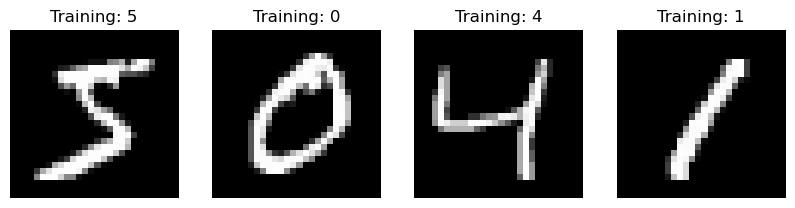

In [5]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, images, labels):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray)
    ax.set_title("Training: " + label)

# Prepare Datasets

### Split data into training and tests sets, also scale input values to a value between 0 and 1

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels, test_size=0.2, shuffle=True
)
X_train = X_train / 255.0
X_test = X_test / 255.0

# highest value of any pixel is 255.0

# Create Autoencoder

### Create the Encoder

In [7]:
encoder = Sequential(name="Encoder")

encoder.add(Flatten(input_shape = (28, 28)))
encoder.add(Dense(784, activation="relu"))
encoder.add(Dense(392, activation="relu"))
encoder.add(Dense(10, activation="relu"))

Metal device set to: Apple M1 Max


2022-09-06 12:21:43.765794: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-06 12:21:43.765969: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Create the Decoder

In [8]:
decoder = Sequential(name="Decoder")

decoder.add(Dense(392, activation="relu"))
decoder.add(Dense(784, activation="sigmoid"))
decoder.add(Reshape((28, 28)))

### Combine the encoder and decoder

In [9]:
autoencoder = Sequential([encoder, decoder], name="Autoencoder")

### Compile the model

In [10]:
autoencoder.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

### Train the model

In [11]:
history = autoencoder.fit(
    X_train, # Samples
    X_train, # Labels
    batch_size=512,
    epochs=100,
    verbose=0
)

2022-09-06 12:21:50.241940: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-06 12:21:50.423215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# Visualize our results

### Fetch 10 images from the test set, one for each number

In [19]:
# Create list of all numbers between 0 -> 10
all_numbers = [str(i) for i in list(range(0,10))]

# Get the index of one image for each value between 0 -> 10
index_of_numbers= get_index_of_values(y_test, all_numbers)

# Get 10 images, one for each number
test_images = X_test[index_of_numbers]

### Use the autoencoder on the 10 images

In [20]:
preds = autoencoder.predict(test_images)

1/1 [==============================] - 0s 10ms/step


### Visualize the original images

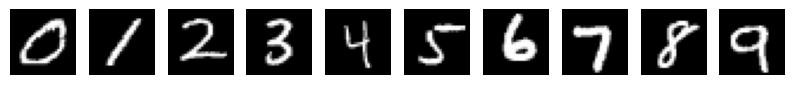

In [21]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))
for ax, image in zip(axes, test_images):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray)

### Visualize the copies made by the autoencoder

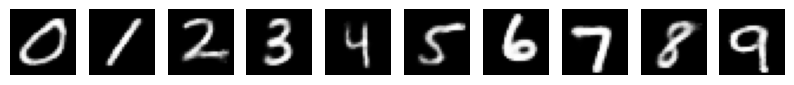

In [22]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))
for ax, image in zip(axes, preds):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray)

# Visualize the internal representation of the numbers

### Extract encoder from autoencoder

In [23]:
encoder = autoencoder.layers[0]

### Get latent representations from test images

In [24]:
latent_representations = encoder.predict(test_images)

1/1 [==============================] - 0s 29ms/step


2022-09-06 12:24:48.215148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Reshape and visualize latent representations

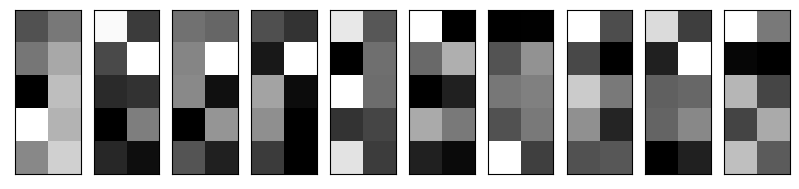

In [25]:
latent_images = latent_representations.reshape((10,5,2))

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))
for ax, image in zip(axes, latent_images):
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.imshow(image, cmap=plt.cm.gray)

# Visualize internal rep. of the same number

In [33]:
# Get index of 4 images containing the number 4
indices = get_n_indices_of_value(y_test, "4", 10)

In [34]:
number_4_images = X_test[indices]

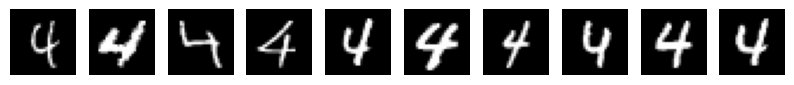

In [35]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))
for ax, image in zip(axes, number_4_images):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray)

In [36]:
number_4_preds = autoencoder.predict(number_4_images)

1/1 [==============================] - 0s 10ms/step


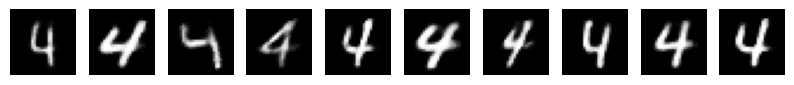

In [37]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))
for ax, image in zip(axes, number_4_preds):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray)

In [38]:
number_4_latent = encoder.predict(number_4_images)

1/1 [==============================] - 0s 7ms/step


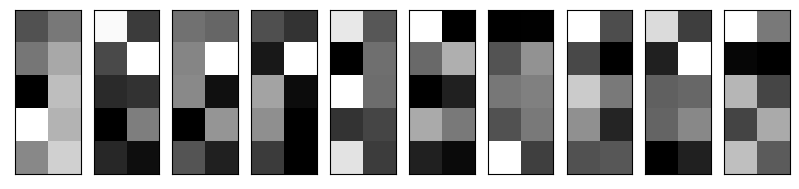

In [39]:
latent_4_images = number_4_latent.reshape((10,5,2))

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))
for ax, image in zip(axes, latent_images):
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.imshow(image, cmap=plt.cm.gray)

# Helper Functions

In [13]:
def get_index_of_values(array, values):
    sorter = np.argsort(array)
    return sorter[np.searchsorted(array, values, sorter=sorter)]

def get_n_indices_of_value(array, value, n):
    return np.where(array == value)[0][0:n]